# NLP Assignment 1 (40% of grade): Sentiment Analysis from Tweets

This coursework will involve you implementing functions for a text classifier, which you will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question. **NB:** this report is strictly limited to 2 pages, and any additional pages will not be considered during marking. You are expected to write concisely within the 2 pages, and any additional texts beyond this will not be considered as part of the report.

In [1]:
import csv                               # csv reader
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
# Cell 2: NEW CELL - Download NLTK data 
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /Users/voodoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/voodoo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/voodoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/voodoo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/voodoo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')  #delimiter='\t' tells Python's CSV reader that columns seperated by tab, not comma
        for line in reader:                         
            (label, text) = parse_data_line(line)   # NOTE csv file contains [row_id, label, text]. parse_data_line() extracts: (label, text)
            raw_data.append((text, label))          # .append is a list method. NOTE raw_data is a list of (text, label)

# Splits raw_data into training and test sets, converting text to feature vectors for both.

def split_and_preprocess_data(percentage):      # NOTE how this function splits AND preprocesses
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples)) #NOTE line that references % !!
    train_data.clear()
    test_data.clear()
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((text, label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((text, label))
        
def parse_data_line(data_line):
    """Return a tuple of the label as just POSITIVE or NEGATIVE and the statement"""
    return (data_line[1], data_line[2])  #NOTE this gets rid of ID in first column. we dont need it


# NOTE you might want to alter this when you stem and lemmatise 
def pre_process(text):
    """Lowercase, tokenize, and lemmatise text; returns clean word tokens."""
    text = text.lower()
    tokens = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if any(char.isalnum() for char in token)
    ]

    return tokens


# quick sanity check
text = "RT @user: I love this movie! #awesome https://t.co/abc123"
result = pre_process(text)
print(result)


['rt', 'user', 'i', 'love', 'this', 'movie', 'awesome', 'http', '//t.co/abc123']


In [4]:
# test
text = "RT @colonelkickhead: Another bloody instant restaurant week?!?! Seriously! They just jumped the shark riding two other sharks powered by sh…"
pre_process(text)

['rt',
 'colonelkickhead',
 'another',
 'bloody',
 'instant',
 'restaurant',
 'week',
 'seriously',
 'they',
 'just',
 'jumped',
 'the',
 'shark',
 'riding',
 'two',
 'other',
 'shark',
 'powered',
 'by',
 'sh…']

In [5]:
#Loading opinion lexicon
def load_opinion_lexicon():
    """Load positive and negative word lists from opinion lexicon"""
    # Read positive words
    with open('positive-words.txt', 'r', encoding='utf-8', errors='ignore') as f:
        positive_words = set(line.strip() for line in f 
                           if line.strip() and not line.startswith(';'))
    
    # Read negative words
    with open('negative-words.txt', 'r', encoding='utf-8', errors='ignore') as f:
        negative_words = set(line.strip() for line in f 
                           if line.strip() and not line.startswith(';'))
    
    return positive_words, negative_words

pos_words, neg_words = load_opinion_lexicon()
print(f"Loaded {len(pos_words)} positive words")
print(f"Loaded {len(neg_words)} negative words")

Loaded 2006 positive words
Loaded 4783 negative words


# Question 1: Basic Feature Extraction (10 marks)

In [6]:
import glob
from nltk.tbl import feature


global_feature_dict = {} # A global dictionary of features

#Function takes as input list and returns bag-of-words representation as feature_dict
def to_feature_vector(tokens):
    """Bag-of-words + opinion lexicon features"""
    feature_dict = {}
    
    # Standard bag-of-words
    for token in tokens:
        feature_dict[token] = feature_dict.get(token, 0) + 1
    
    # Opinion lexicon features (uses pos_words and neg_words loaded above)
    pos_count = sum(1 for token in tokens if token in pos_words)
    neg_count = sum(1 for token in tokens if token in neg_words)
    
    feature_dict['LEXICON_POS_COUNT'] = pos_count
    feature_dict['LEXICON_NEG_COUNT'] = neg_count
    feature_dict['LEXICON_RATIO'] = pos_count - neg_count
    
    # Update global dict
    if token not in global_feature_dict:
        global_feature_dict[token] = len(global_feature_dict)
    
    return feature_dict

text = "RT @colonelkickhead: Another bloody instant restaurant week?!?! Seriously! They just jumped the shark riding two other sharks powered by sh…"

print(to_feature_vector(pre_process(text)))

print(f"Unique token IDs {global_feature_dict}\nNumber of unique tokens = {len(global_feature_dict)}")
        


{'rt': 1, 'colonelkickhead': 1, 'another': 1, 'bloody': 1, 'instant': 1, 'restaurant': 1, 'week': 1, 'seriously': 1, 'they': 1, 'just': 1, 'jumped': 1, 'the': 1, 'shark': 2, 'riding': 1, 'two': 1, 'other': 1, 'powered': 1, 'by': 1, 'sh…': 1, 'LEXICON_POS_COUNT': 0, 'LEXICON_NEG_COUNT': 3, 'LEXICON_RATIO': -3}
Unique token IDs {'sh…': 0}
Number of unique tokens = 1


In [7]:
# Custom sklearn transformer for extracting lexicon-based features
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class LexiconFeatures(BaseEstimator, TransformerMixin):
    """Extract sentiment lexicon features"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """X is a list of raw text strings"""
        features = []
        for text in X:
            tokens = pre_process(text)
            pos_count = sum(1 for t in tokens if t in pos_words)
            neg_count = sum(1 for t in tokens if t in neg_words)
            features.append([pos_count, neg_count, pos_count - neg_count])
        return np.array(features)

In [8]:

# TRAINING AND VALIDATING OUR CLASSIFIER

# This Function takes training data and returns a trained classifier
def train_classifier(data):
    print("Training Classifier...")
    texts = [x[0] for x in data]
    labels = [x[1] for x in data]

    pipeline = Pipeline([
        # Three feature extractors run in parallel, outputs concatenated
        ('features', FeatureUnion(transformer_list=[
            
            # Word-level TF-IDF: unigrams + bigrams for semantic content and negation patterns
            ('word_tfidf', TfidfVectorizer(
                tokenizer=pre_process,        # Custom tokenizer (lowercase + lemmatize)
                lowercase=False,              # Already handled in pre_process
                ngram_range=(1, 3),           # Bigrams capture phrases like "not_good"
                min_df=2,                     # Filter rare words
                max_df=0.95,                  # Filter common non-discriminative words
                sublinear_tf=True,            # Log scaling for term frequencies
                token_pattern=None
            )),
            
            # Character-level TF-IDF: captures hashtags, emoticons, misspellings
            ('char_tfidf', TfidfVectorizer(
                analyzer='char',
                ngram_range=(3, 5),
                min_df=2,
                max_df=0.95,
                sublinear_tf=True
            )),
            
            # Lexicon features: explicit sentiment signal from Opinion Lexicon
            ('lexicon', LexiconFeatures())
        ])),
        
        # Logistic Regression classifier
        ('logreg', LogisticRegression(
            C=5.0,                           # Less regularization for better fit
            class_weight='balanced',          # Handle class imbalance
            max_iter=2000,                    # Ensure convergence
            solver='liblinear'
        ))
    ])

    pipeline.fit(texts, labels)
    return pipeline



# Question 2: Cross-validation (20 marks)

In [9]:
# solution
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import random

# Updated prediction helpers (overrides earlier definitions)
def predict_labels(samples, classifier):
    """Given raw text samples, return predicted labels from the trained classifier."""
    return classifier.predict(samples)


def predict_label_from_raw(sample, classifier):
    """Convenience helper for a single raw text sample."""
    return classifier.predict([sample])[0]


# Initialize and load data
raw_data = []
train_data = []   # Will hold (text, label) tuples after preprocessing
test_data = []     # Held-out 20% for final testing

load_data('sentiment-dataset.tsv')   #csv file contains [row_id, label, text]
print(f"Loaded {len(raw_data)} tweets")

# Split into 80% train / 20% test
split_and_preprocess_data(0.8)
print(f"Training data: {len(train_data)}")
print(f"Test data: {len(test_data)}")

def cross_validate(dataset, folds):
    """
    Perform k-fold cross validation on the dataset of (text, label) tuples.
    :param dataset: list of (text, label) tuples
    :param folds: number of folds (k=10)
    :return: dictionary with average precision, recall, f1, accuracy
    """
    results = {'precision': [], 'recall': [], 'f1': [], 'accuracy': []}

    random.seed(42)  # reproducibility
    data = dataset[:]  # shallow copy
    random.shuffle(data)

    fold_size = len(data) // folds

    for fold_idx in range(folds):
        start = fold_idx * fold_size
        end = start + fold_size if fold_idx < folds - 1 else len(data)

        print(f"Fold {fold_idx+1}/{folds}: Testing on items {start} - {end}")

        test_fold = data[start:end]
        train_fold = data[:start] + data[end:]

        classifier = train_classifier(train_fold)

        test_texts = [x[0] for x in test_fold]
        test_labels = [x[1] for x in test_fold]

        predictions = predict_labels(test_texts, classifier)

        precision, recall, f1, _ = precision_recall_fscore_support(
            test_labels,
            predictions,
            average='weighted',
            zero_division=0
        )
        acc = accuracy_score(test_labels, predictions)

        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['accuracy'].append(acc)

        print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}\n")

    cv_results = {
        'precision': sum(results['precision']) / folds,
        'recall': sum(results['recall']) / folds,
        'f1': sum(results['f1']) / folds,
        'accuracy': sum(results['accuracy']) / folds
    }

    print("=" * 50)
    print("Average Cross-Validation Results:")
    print(f"  Precision: {cv_results['precision']:.4f}")
    print(f"  Recall:    {cv_results['recall']:.4f}")
    print(f"  F1 Score:  {cv_results['f1']:.4f}")
    print(f"  Accuracy:  {cv_results['accuracy']:.4f}")
    print("=" * 50)

    return cv_results

# Cross-validate on TRAIN_DATA (80%), not raw_data (100%)!
cv_results = cross_validate(train_data, 10)


Loaded 33540 tweets
Training data: 26832
Test data: 6708
Fold 1/10: Testing on items 0 - 2683
Training Classifier...
  Precision: 0.8900, Recall: 0.8886, F1: 0.8891, Accuracy: 0.8886

Fold 2/10: Testing on items 2683 - 5366
Training Classifier...
  Precision: 0.8765, Recall: 0.8759, F1: 0.8761, Accuracy: 0.8759

Fold 3/10: Testing on items 5366 - 8049
Training Classifier...
  Precision: 0.8886, Recall: 0.8889, F1: 0.8887, Accuracy: 0.8889

Fold 4/10: Testing on items 8049 - 10732
Training Classifier...
  Precision: 0.8853, Recall: 0.8852, F1: 0.8853, Accuracy: 0.8852

Fold 5/10: Testing on items 10732 - 13415
Training Classifier...
  Precision: 0.8913, Recall: 0.8908, F1: 0.8910, Accuracy: 0.8908

Fold 6/10: Testing on items 13415 - 16098
Training Classifier...
  Precision: 0.8810, Recall: 0.8811, F1: 0.8810, Accuracy: 0.8811

Fold 7/10: Testing on items 16098 - 18781
Training Classifier...
  Precision: 0.8840, Recall: 0.8826, F1: 0.8831, Accuracy: 0.8826

Fold 8/10: Testing on items 1

In [10]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
1


In [11]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold 1/10: Testing on items 0 - 2683
Training Classifier...
  Precision: 0.8900, Recall: 0.8886, F1: 0.8891, Accuracy: 0.8886

Fold 2/10: Testing on items 2683 - 5366
Training Classifier...
  Precision: 0.8765, Recall: 0.8759, F1: 0.8761, Accuracy: 0.8759

Fold 3/10: Testing on items 5366 - 8049
Training Classifier...
  Precision: 0.8886, Recall: 0.8889, F1: 0.8887, Accuracy: 0.8889

Fold 4/10: Testing on items 8049 - 10732
Training Classifier...
  Precision: 0.8853, Recall: 0.8852, F1: 0.8853, Accuracy: 0.8852

Fold 5/10: Testing on items 10732 - 13415
Training Classifier...
  Precision: 0.8913, Recall: 0.8908, F1: 0.8910, Accuracy: 0.8908

Fold 6/10: Testing on items 13415 - 16098
Training Classifier...
  Precision: 0.8810, Recall: 0.8811, F1: 0.8810, Accuracy: 0.8811

Fold 7/10: Testing on items 16098 - 18781
Training Classifier...
  Precision: 0.8840, Recall: 0.8826, F1: 0.8831, Accuracy: 0.8826

Fold 8/10: Testing on items 18781 - 21464
Training Classifier...
  Precision: 0.8936, 

{'precision': 0.8865214688001937,
 'recall': 0.8859195389135401,
 'f1': 0.8861476880634471,
 'accuracy': 0.8859195389135401}

# Question 3: Error Analysis (20 marks)

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Training on 24149 samples
Testing on 2683 samples
Training Classifier...

Confusion Matrix:
[[ 652  166]
 [ 143 1722]]

Format:
                Predicted Negative | Predicted Positive
Actually Negative |      TN          |       FP
Actually Positive |      FN          |       TP

Where:
TN = True Negative  (correctly predicted negative)
FP = False Positive (wrongly predicted positive, actually negative)
FN = False Negative (wrongly predicted negative, actually positive)
TP = True Positive  (correctly predicted positive)


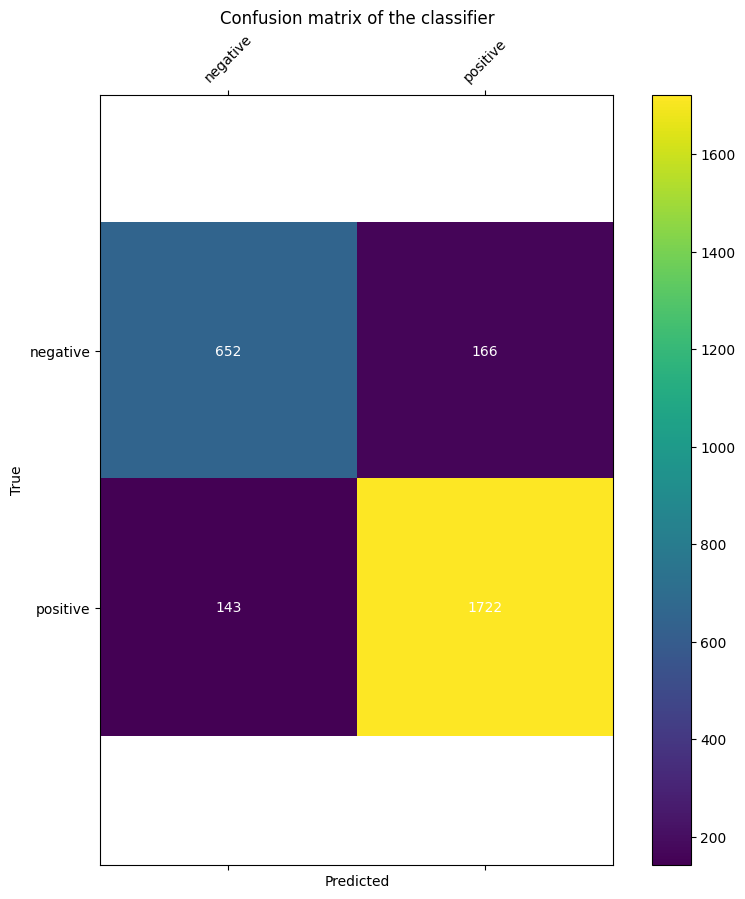


ERROR SUMMARY:
False Positives (predicted positive, actually negative): 166
False Negatives (predicted negative, actually positive): 143
Total Errors: 309
Accuracy: 0.8848

Error analysis saved to 'error_analysis_q4.txt'


In [13]:

# =============================================================================
# QUESTION 3: ERROR ANALYSIS (20 marks)
# =============================================================================

from sklearn import metrics
import numpy as np


# Splitting training data for error analysis
# We use the first fold (10%) of train data as our test set for error analysis
# and the remaining 9 folds (90%) for training

fold_size = int(len(train_data) / 10)
test_fold = train_data[:fold_size]
train_folds = train_data[fold_size:]

print(f"Training on {len(train_folds)} samples")
print(f"Testing on {len(test_fold)} samples")

# Train the classifier on 9 folds
classifier = train_classifier(train_folds)

# Prepare test data and get predictions
test_texts = [text for text, _ in test_fold]
test_labels = [label for _, label in test_fold]
predictions = predict_labels(test_texts, classifier)

# Create and display confusion matrix
labels = ['negative', 'positive']
cm = metrics.confusion_matrix(test_labels, predictions, labels=labels)

print("\nConfusion Matrix:")
print(cm)
print("\nFormat:")
print("                Predicted Negative | Predicted Positive")
print("Actually Negative |      TN          |       FP")
print("Actually Positive |      FN          |       TP")
print("\nWhere:")
print("TN = True Negative  (correctly predicted negative)")
print("FP = False Positive (wrongly predicted positive, actually negative)")
print("FN = False Negative (wrongly predicted negative, actually positive)")
print("TP = True Positive  (correctly predicted positive)")

confusion_matrix_heatmap(test_labels, predictions, labels)

# STEP 5: Extract misclassified examples (False Positives & False Negatives)
false_positives = []
false_negatives = []

for i, (text, true_label) in enumerate(test_fold):
    pred_label = predictions[i]
    if pred_label == 'positive' and true_label == 'negative':
        false_positives.append((text, true_label, pred_label))
    elif pred_label == 'negative' and true_label == 'positive':
        false_negatives.append((text, true_label, pred_label))

print(f"\n{'='*80}")
print("ERROR SUMMARY:")
print(f"False Positives (predicted positive, actually negative): {len(false_positives)}")
print(f"False Negatives (predicted negative, actually positive): {len(false_negatives)}")
print(f"Total Errors: {len(false_positives) + len(false_negatives)}")
print(f"Accuracy: {(len(test_fold) - len(false_positives) - len(false_negatives)) / len(test_fold):.4f}")

# STEP 6: Save all errors to file for detailed analysis
with open('error_analysis_q4.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("QUESTION 3 (Using model built for Q4): ERROR ANALYSIS\n")
    f.write("=" * 80 + "\n\n")

    f.write(f"FALSE POSITIVES (Predicted Positive, Actually Negative): {len(false_positives)}\n")
    f.write("=" * 80 + "\n")
    f.write("These are NEGATIVE tweets that the classifier wrongly thought were POSITIVE.\n")
    f.write("Look for patterns: sarcasm? positive words in negative context?\n")
    f.write("=" * 80 + "\n\n")

    for idx, (text, true_label, pred_label) in enumerate(false_positives, 1):
        f.write(f"FALSE POSITIVE #{idx}\n")
        f.write("-" * 80 + "\n")
        f.write(f"Tweet: {text}\n")
        tokens = pre_process(text)
        f.write(f"Preprocessed tokens: {' '.join(tokens)}\n")
        f.write(f"True Label: {true_label}\n")
        f.write(f"Predicted Label: {pred_label}\n")
        f.write("-" * 80 + "\n\n")

    f.write("\n" + "=" * 80 + "\n")
    f.write(f"FALSE NEGATIVES (Predicted Negative, Actually Positive): {len(false_negatives)}\n")
    f.write("=" * 80 + "\n")
    f.write("These are POSITIVE tweets that the classifier wrongly thought were NEGATIVE.\n")
    f.write("Look for patterns: weak positives? negated negatives (not bad)?\n")
    f.write("=" * 80 + "\n\n")

    for idx, (text, true_label, pred_label) in enumerate(false_negatives, 1):
        f.write(f"FALSE NEGATIVE #{idx}\n")
        f.write("-" * 80 + "\n")
        f.write(f"Tweet: {text}\n")
        tokens = pre_process(text)
        f.write(f"Preprocessed tokens: {' '.join(tokens)}\n")
        f.write(f"True Label: {true_label}\n")
        f.write(f"Predicted Label: {pred_label}\n")
        f.write("-" * 80 + "\n\n")

print(f"\n{'='*80}")
print("Error analysis saved to 'error_analysis_q4.txt'")
print(f"{'='*80}")


# Question 4: Optimising pre-processing and feature extraction (50 marks)

**Note:** it is advisable to implement question 4 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

In [14]:
# Finally, check the accuracy of your classifier by training on all the training data
# and testing on the held-out test set
# Only run this ONCE when you are happy with your cross-validation results

functions_complete = True  # set to True once you're ready for final evaluation
if functions_complete:
    classifier = train_classifier(train_data)  # train on full 80% training split
    test_texts = [text for text, _ in test_data]
    test_true = [label for _, label in test_data]
    test_pred = predict_labels(test_texts, classifier)
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted')
    accuracy = accuracy_score(test_true, test_pred)
    print("Done training!\nFinal Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {final_scores[0]:.4f}")
    print(f"Recall: {final_scores[1]:.4f}")
    print(f"F1 Score: {final_scores[2]:.4f}")
else:
    print('Set functions_complete = True to run the final evaluation.')


Training Classifier...
Done training!
Final Performance:
Accuracy: 0.8788
Precision: 0.8795
Recall: 0.8788
F1 Score: 0.8791
